Mounted at /content/drive
✅ Model loaded and ready for inference!


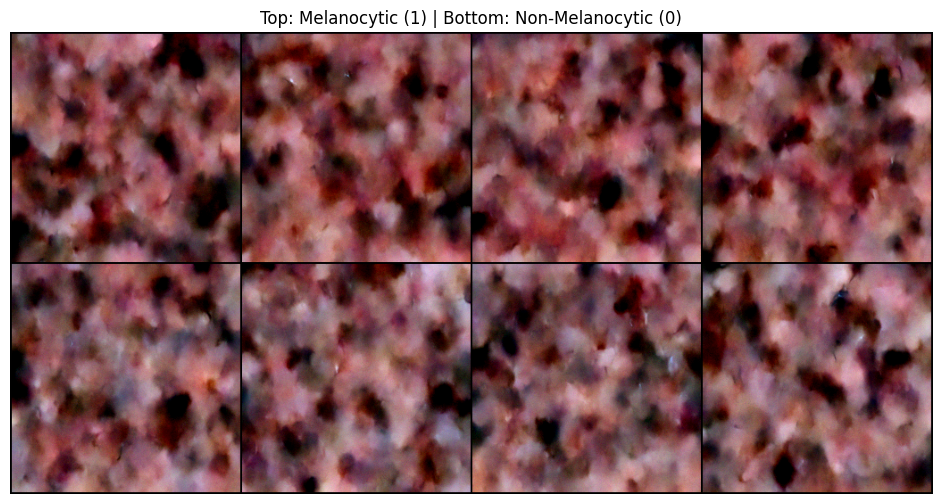

In [ ]:
# =============================
# CONTROLLED GENERATION: MELANOCYTIC ONLY - 256×256 MODEL
# =============================

import torch
import torch.nn as nn
import os
import numpy as np
import pandas as pd
from torchvision.utils import make_grid
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import math

from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =============================
# MODEL DEFINITION (256x256 UNET with Skip Connections)
# =============================
class UNetBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.block(x)

def get_timestep_embedding(timesteps, dim=64):
    half_dim = dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=timesteps.device) * -emb)
    emb = timesteps[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    return emb

class SimpleUNet(nn.Module):
    def __init__(self, img_channels=3, metadata_size=12):
        super().__init__()
        self.meta_fc = nn.Linear(metadata_size, 64)
        self.time_mlp = nn.Sequential(nn.Linear(64, 128), nn.ReLU(), nn.Linear(128, 64))

        # Deep U-Net (down)
        self.down1 = UNetBlock(img_channels + 128, 64)
        self.down2 = UNetBlock(64, 128)
        self.down3 = UNetBlock(128, 256)
        self.down4 = UNetBlock(256, 512)

        self.bottleneck = UNetBlock(512, 512)

        # Up path
        self.up1 = UNetBlock(512 + 512, 256)
        self.up2 = UNetBlock(256 + 256, 128)
        self.up3 = UNetBlock(128 + 128, 64)
        self.up4 = UNetBlock(64 + 64, 64)

        self.final = nn.Conv2d(64, img_channels, kernel_size=1)

    def forward(self, x, t, metadata):
        B, _, H, W = x.shape
        t_embed = get_timestep_embedding(t, dim=64)
        t_embed = self.time_mlp(t_embed).view(B, -1, 1, 1).expand(B, -1, H, W)
        m_embed = self.meta_fc(metadata).view(B, -1, 1, 1).expand(B, 64, H, W)
        x = torch.cat([x, t_embed, m_embed], dim=1)

        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        b = self.bottleneck(d4)
        u1 = self.up1(torch.cat([b, d4], dim=1))
        u2 = self.up2(torch.cat([u1, d3], dim=1))
        u3 = self.up3(torch.cat([u2, d2], dim=1))
        u4 = self.up4(torch.cat([u3, d1], dim=1))
        return self.final(u4)

# =============================
# LOAD CHECKPOINT
# =============================
MODEL_PATH = "/content/drive/MyDrive/DATABase/trained_diffusion_model/best_model.pth"
metadata_size = 12

diffusion_model = SimpleUNet(img_channels=3, metadata_size=metadata_size).to(device)
checkpoint = torch.load(MODEL_PATH, map_location=device)
if "model_state_dict" in checkpoint:
    diffusion_model.load_state_dict(checkpoint["model_state_dict"])
else:
    diffusion_model.load_state_dict(checkpoint)
diffusion_model.eval()

print("✅ Model loaded and ready for inference!")

# =============================
# DDPM Noise Schedule
# =============================
def cosine_noise_schedule(timesteps, s=0.005):
    t = torch.linspace(0, timesteps, timesteps + 1, device=device) / timesteps
    alpha_bar = torch.cos((t + s) / (1 + s) * math.pi / 2) ** 2
    betas = 1 - (alpha_bar[1:] / alpha_bar[:-1])
    return betas.clamp(1e-5, 0.02)

timesteps = 1000
betas = cosine_noise_schedule(timesteps)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

site_to_idx = {
    'back': 0, 'chest': 1, 'lower extremity': 2, 'upper extremity': 3,
    'torso': 4, 'head/neck': 5, 'abdomen': 6
}
anatom_sites = list(site_to_idx.keys())

# =============================
# IMAGE GENERATION FUNCTION
# =============================
SAVE_FOLDER = "/content/drive/MyDrive/DATABase/Synthetic_Melanocytic_Control/"
os.makedirs(SAVE_FOLDER, exist_ok=True)
METADATA_FILE = os.path.join(SAVE_FOLDER, "generated_metadata.csv")

@torch.no_grad()
def generate_melanocytic_images(num_samples=8, melanocytic_value=1):
    metadata_list = []
    metadata_tensor_list = []

    for i in range(num_samples):
        sex = 1  # female
        age_group = [0, 1, 0]  # middle
        site_label = "back"
        site_vector = [0] * len(site_to_idx)
        site_vector[site_to_idx[site_label]] = 1

        metadata_vector = torch.tensor(
            [melanocytic_value, sex] + age_group + site_vector,
            dtype=torch.float, device=device
        )
        metadata_tensor_list.append(metadata_vector)

        metadata_list.append({
            "image_id": f"melanocytic_{melanocytic_value}_{i}.jpg",
            "melanocytic": melanocytic_value,
            "sex": "female",
            "age_group": "middle",
            "anatom_site_general": site_label
        })

    metadata_tensor = torch.stack(metadata_tensor_list, dim=0)
    x = torch.randn((num_samples, 3, 256, 256), device=device)

    for t in reversed(range(1, timesteps)):
        t_batch = torch.full((num_samples,), t, device=device, dtype=torch.long)
        predicted_noise = diffusion_model(x, t_batch, metadata_tensor)

        alpha_t = alphas[t].view(1, 1, 1, 1)
        beta_t = betas[t].view(1, 1, 1, 1)
        alpha_cumprod_t = alphas_cumprod[t].view(1, 1, 1, 1)

        coef = (1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t)
        x = (1 / torch.sqrt(alpha_t)) * (x - coef * predicted_noise)

        if t > 1:
            noise = torch.randn_like(x)
            x += torch.sqrt(beta_t) * noise

    x = x.clamp(-1, 1)

    for i, img in enumerate(x):
        img_np = ((img.cpu().numpy() + 1) * 127.5).astype(np.uint8).transpose(1, 2, 0)
        Image.fromarray(img_np).save(os.path.join(SAVE_FOLDER, f"melanocytic_{melanocytic_value}_{i}.jpg"))

    pd.DataFrame(metadata_list).to_csv(METADATA_FILE, mode='a', header=not os.path.exists(METADATA_FILE), index=False)
    return x

# =============================
# RUN & VISUALIZE
# =============================
mel_imgs = generate_melanocytic_images(num_samples=4, melanocytic_value=1)
nonmel_imgs = generate_melanocytic_images(num_samples=4, melanocytic_value=0)

combined = torch.cat([mel_imgs.cpu(), nonmel_imgs.cpu()], dim=0)
plt.figure(figsize=(12, 6))
plt.axis("off")
plt.title("Top: Melanocytic (1) | Bottom: Non-Melanocytic (0)")
plt.imshow(np.transpose(make_grid(combined, nrow=4, padding=2, normalize=True), (1, 2, 0)))
plt.show()
